# Deliverable 3.2 - MPC Velocity Controllers with Reference Tracking

This notebook implements and tests MPC controllers with the ability to track constant velocity references (x, y, z) and roll angle references.

In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget

In [2]:
# MPC import
import numpy as np
import matplotlib.pyplot as plt
from LinearMPC.MPCVelControl import MPCVelControl
from LinearMPC.MPCControl_xvel import MPCControl_xvel
from LinearMPC.MPCControl_yvel import MPCControl_yvel
from LinearMPC.MPCControl_zvel import MPCControl_zvel
from LinearMPC.MPCControl_roll import MPCControl_roll
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

## Design Procedure and Tuning Parameters

### Extension from Deliverable 3.1

To extend the controllers from stabilization (Deliverable 3.1) to reference tracking, we modify the cost function:

**Original (Stabilization)**:
$$J = \sum_{k=0}^{N-1} \left( x_k^T Q x_k + u_k^T R u_k \right) + x_N^T Q_f x_N$$

**Modified (Tracking)**:
$$J = \sum_{k=0}^{N-1} \left( (x_k - x_{ref})^T Q (x_k - x_{ref}) + u_k^T R u_k \right) + (x_N - x_{ref})^T Q_f (x_N - x_{ref})$$

### Key Design Decisions:

1. **Reference Handling**: References are specified in **absolute coordinates** (e.g., $v_x = 3$ m/s, $\gamma = 35°$) but converted internally to delta coordinates relative to the trim point.

2. **Terminal Set**: We maintain the same terminal sets from 3.1. The terminal constraint ensures the state reaches a neighborhood of the reference (after transformation to delta coordinates).

3. **Tuning Parameters**: Same as Deliverable 3.1:
   - **X/Y velocity**: $Q = \text{diag}(1, 20, 50)$, $R = 1$
   - **Z velocity**: $Q = 100$, $R = 1$
   - **Roll**: $Q = \text{diag}(50, 200)$, $R = 1$
   - **Horizon**: $H = 7$ seconds

4. **Why Same Tuning Works**: The relative weighting between tracking error and control effort remains optimal. Higher weights on velocity/angle ensure fast convergence to the reference, regardless of whether that reference is zero or non-zero.

### Implementation Notes:

- Each controller accepts `x_target` parameter in `get_u()`
- If `x_target=None`, defaults to trim (equivalent to stabilization)
- Subsystem extraction: automatically extracts relevant states from full state vector
- Constraints remain in delta coordinates, ensuring feasibility

In [3]:
# Setup parameters
Ts = 0.05  # Sampling time
H = 7.0    # Horizon in seconds

# Create rocket and controllers
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)

# Create MPC controller
mpc = MPCVelControl().new_controller(rocket, Ts, H)

print("Controllers created successfully!")
print(f"Trim state velocities: vx={xs[6]:.3f}, vy={xs[7]:.3f}, vz={xs[8]:.3f} m/s")
print(f"Trim roll angle: gamma={np.rad2deg(xs[5]):.3f} deg")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Controllers created successfully!
Trim state velocities: vx=0.000, vy=0.000, vz=0.000 m/s
Trim roll angle: gamma=0.000 deg


## Individual Controller Tests

We test each controller separately to verify tracking capability before combining them.

## Open-Loop Predictions

Before testing closed-loop tracking, we verify each controller's open-loop predictions to ensure the optimization is formulated correctly.

X-controller initial control: [-0.2618]
X-controller trajectory shape: states=(3, 141), inputs=(1, 140)


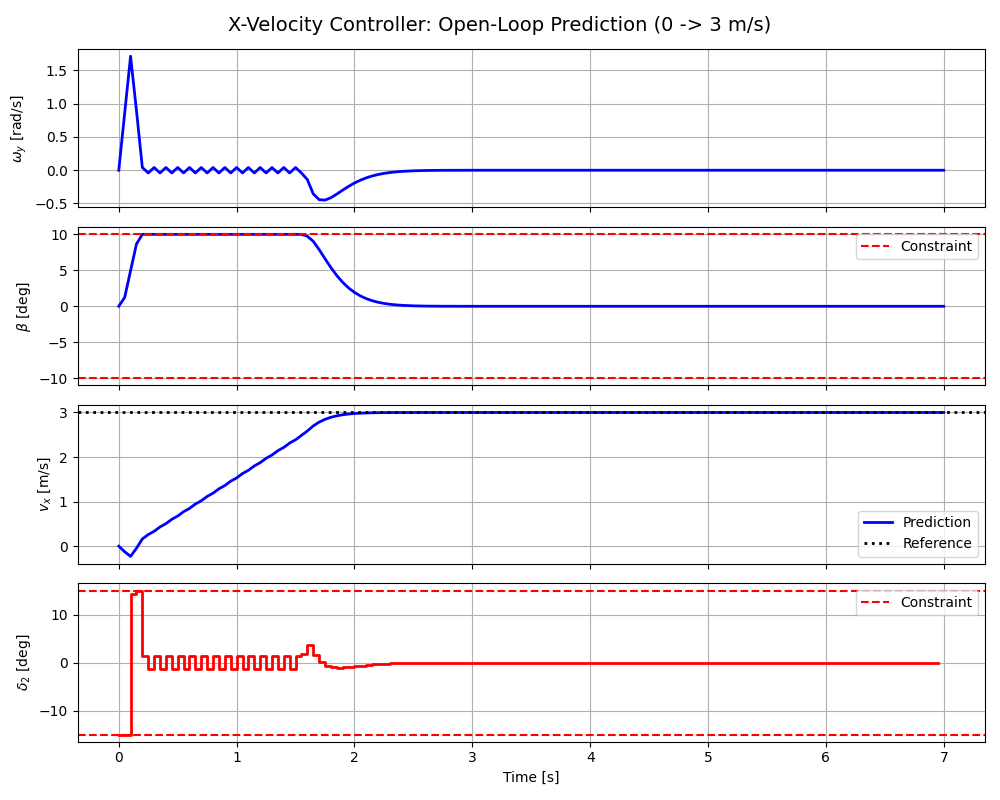

In [4]:
# Test X-velocity controller open-loop: 0 -> 3 m/s
x0_x_ol = xs[mpc.mpc_x.x_ids].copy()
x_ref_x_ol = xs.copy()
x_ref_x_ol[mpc.mpc_x.x_ids[2]] = 3.0  # vx = 3 m/s

u0_x, x_traj_x, u_traj_x = mpc.mpc_x.get_u(x0_x_ol, x_target=x_ref_x_ol)

print(f"X-controller initial control: {u0_x}")
print(f"X-controller trajectory shape: states={x_traj_x.shape}, inputs={u_traj_x.shape}")

# Plot open-loop prediction
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('X-Velocity Controller: Open-Loop Prediction (0 -> 3 m/s)', fontsize=14)

t_ol = np.arange(x_traj_x.shape[1]) * Ts

axes[0].plot(t_ol, x_traj_x[0, :], 'b-', linewidth=2)
axes[0].set_ylabel(r'$\omega_y$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t_ol, np.rad2deg(x_traj_x[1, :]), 'b-', linewidth=2)
axes[1].axhline(y=10, color='r', linestyle='--', label='Constraint')
axes[1].axhline(y=-10, color='r', linestyle='--')
axes[1].set_ylabel(r'$\beta$ [deg]')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t_ol, x_traj_x[2, :], 'b-', linewidth=2, label='Prediction')
axes[2].axhline(y=3.0, color='k', linestyle=':', linewidth=2, label='Reference')
axes[2].set_ylabel(r'$v_x$ [m/s]')
axes[2].legend()
axes[2].grid(True)

t_u = np.arange(u_traj_x.shape[1]) * Ts
axes[3].step(t_u, np.rad2deg(u_traj_x[0, :]), 'r-', linewidth=2, where='post')
axes[3].axhline(y=15, color='r', linestyle='--', label='Constraint')
axes[3].axhline(y=-15, color='r', linestyle='--')
axes[3].set_ylabel(r'$\delta_2$ [deg]')
axes[3].set_xlabel('Time [s]')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_2_x_openloop.png', dpi=150, bbox_inches='tight')
plt.show()

Roll controller initial control: [8.24520304]


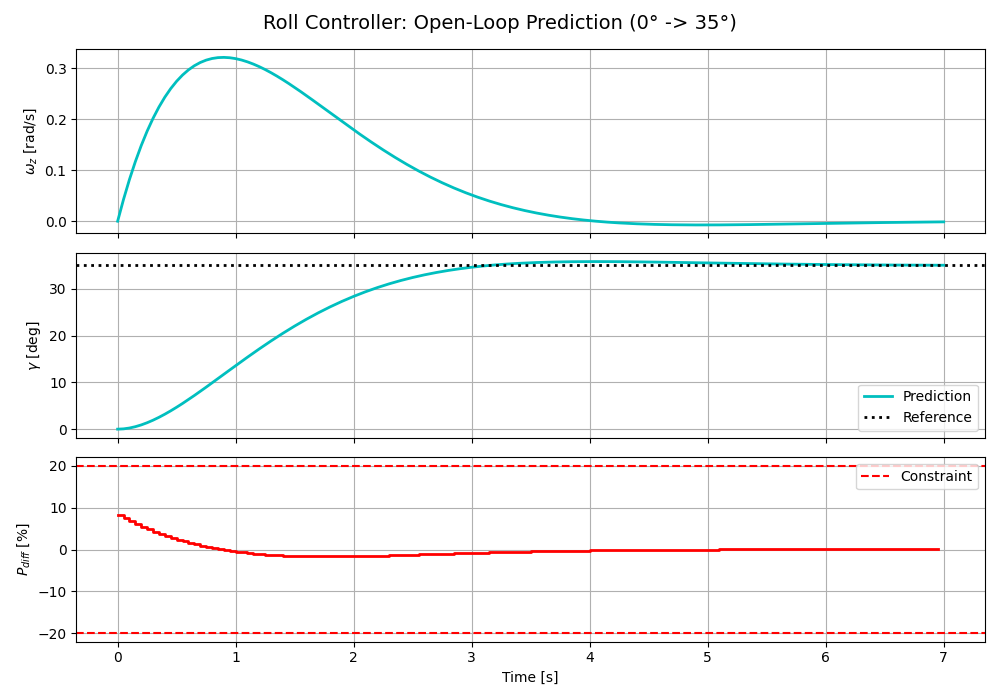

In [5]:
# Test Roll controller open-loop: 0 -> 35 degrees
x0_roll_ol = xs[mpc.mpc_roll.x_ids].copy()
x_ref_roll_ol = xs.copy()
x_ref_roll_ol[mpc.mpc_roll.x_ids[1]] = np.deg2rad(35)  # gamma = 35 deg

u0_roll, x_traj_roll, u_traj_roll = mpc.mpc_roll.get_u(x0_roll_ol, x_target=x_ref_roll_ol)

print(f"Roll controller initial control: {u0_roll}")

# Plot open-loop prediction
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Roll Controller: Open-Loop Prediction (0° -> 35°)', fontsize=14)

t_ol = np.arange(x_traj_roll.shape[1]) * Ts

axes[0].plot(t_ol, x_traj_roll[0, :], 'c-', linewidth=2)
axes[0].set_ylabel(r'$\omega_z$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t_ol, np.rad2deg(x_traj_roll[1, :]), 'c-', linewidth=2, label='Prediction')
axes[1].axhline(y=35, color='k', linestyle=':', linewidth=2, label='Reference')
axes[1].set_ylabel(r'$\gamma$ [deg]')
axes[1].legend()
axes[1].grid(True)

t_u = np.arange(u_traj_roll.shape[1]) * Ts
axes[2].step(t_u, u_traj_roll[0, :], 'r-', linewidth=2, where='post')
axes[2].axhline(y=-20, color='r', linestyle='--', label='Constraint')
axes[2].axhline(y=20, color='r', linestyle='--')
axes[2].set_ylabel(r'$P_{diff}$ [%]')
axes[2].set_xlabel('Time [s]')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_2_roll_openloop.png', dpi=150, bbox_inches='tight')
plt.show()

Z-controller initial control: [80.]


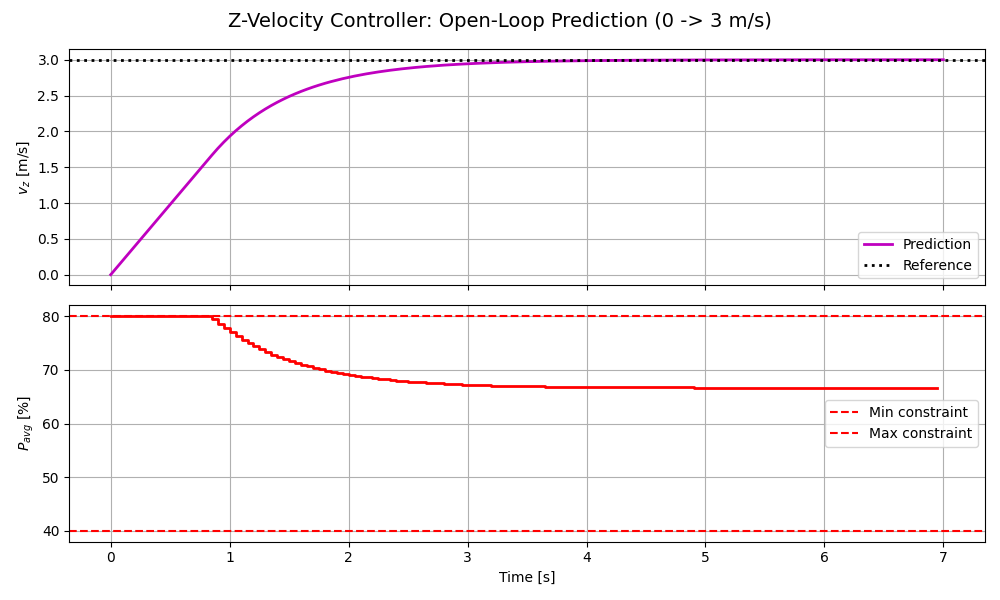

In [6]:
# Test Z-velocity controller open-loop: 0 -> 3 m/s
x0_z_ol = xs[mpc.mpc_z.x_ids].copy()
x_ref_z_ol = xs.copy()
x_ref_z_ol[mpc.mpc_z.x_ids[0]] = 3.0  # vz = 3 m/s

u0_z, x_traj_z, u_traj_z = mpc.mpc_z.get_u(x0_z_ol, x_target=x_ref_z_ol)

print(f"Z-controller initial control: {u0_z}")

# Plot open-loop prediction
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
fig.suptitle('Z-Velocity Controller: Open-Loop Prediction (0 -> 3 m/s)', fontsize=14)

t_ol = np.arange(x_traj_z.shape[1]) * Ts

axes[0].plot(t_ol, x_traj_z[0, :], 'm-', linewidth=2, label='Prediction')
axes[0].axhline(y=3.0, color='k', linestyle=':', linewidth=2, label='Reference')
axes[0].set_ylabel(r'$v_z$ [m/s]')
axes[0].legend()
axes[0].grid(True)

t_u = np.arange(u_traj_z.shape[1]) * Ts
axes[1].step(t_u, u_traj_z[0, :], 'r-', linewidth=2, where='post')
axes[1].axhline(y=40, color='r', linestyle='--', label='Min constraint')
axes[1].axhline(y=80, color='r', linestyle='--', label='Max constraint')
axes[1].set_ylabel(r'$P_{avg}$ [%]')
axes[1].set_xlabel('Time [s]')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_2_z_openloop.png', dpi=150, bbox_inches='tight')
plt.show()

Y-controller initial control: [0.2618]


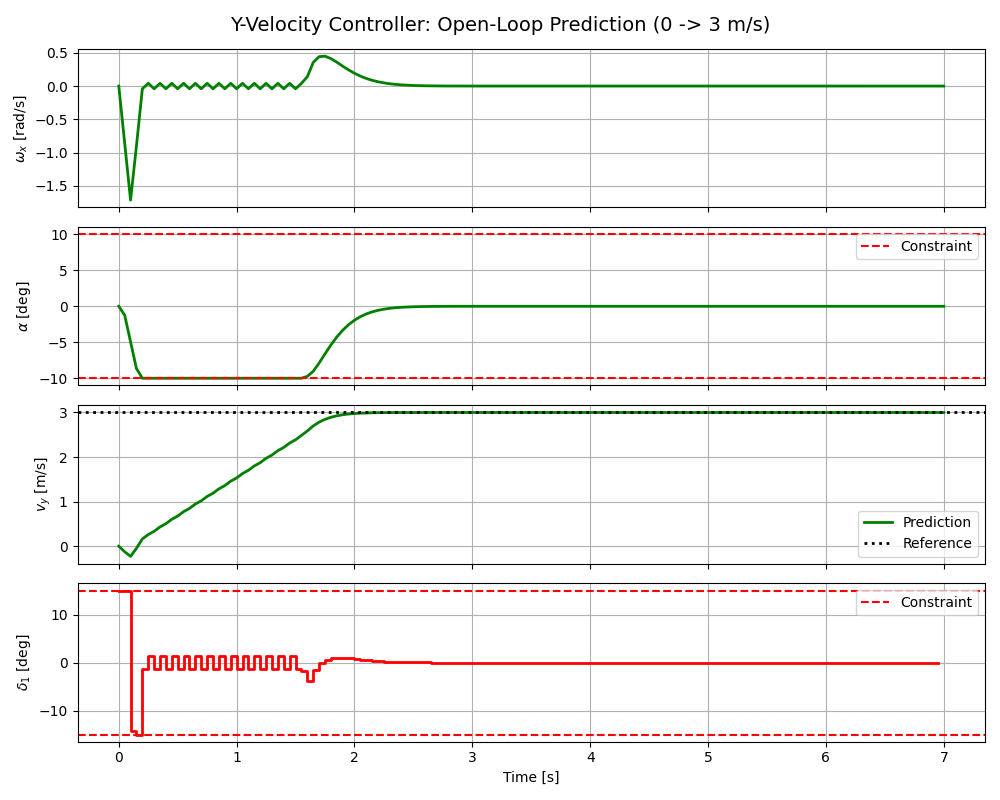

In [7]:
# Test Y-velocity controller open-loop: 0 -> 3 m/s
x0_y_ol = xs[mpc.mpc_y.x_ids].copy()
x_ref_y_ol = xs.copy()
x_ref_y_ol[mpc.mpc_y.x_ids[2]] = 3.0  # vy = 3 m/s

u0_y, x_traj_y, u_traj_y = mpc.mpc_y.get_u(x0_y_ol, x_target=x_ref_y_ol)

print(f"Y-controller initial control: {u0_y}")

# Plot open-loop prediction
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Y-Velocity Controller: Open-Loop Prediction (0 -> 3 m/s)', fontsize=14)

t_ol = np.arange(x_traj_y.shape[1]) * Ts

axes[0].plot(t_ol, x_traj_y[0, :], 'g-', linewidth=2)
axes[0].set_ylabel(r'$\omega_x$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t_ol, np.rad2deg(x_traj_y[1, :]), 'g-', linewidth=2)
axes[1].axhline(y=10, color='r', linestyle='--', label='Constraint')
axes[1].axhline(y=-10, color='r', linestyle='--')
axes[1].set_ylabel(r'$\alpha$ [deg]')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t_ol, x_traj_y[2, :], 'g-', linewidth=2, label='Prediction')
axes[2].axhline(y=3.0, color='k', linestyle=':', linewidth=2, label='Reference')
axes[2].set_ylabel(r'$v_y$ [m/s]')
axes[2].legend()
axes[2].grid(True)

t_u = np.arange(u_traj_y.shape[1]) * Ts
axes[3].step(t_u, np.rad2deg(u_traj_y[0, :]), 'r-', linewidth=2, where='post')
axes[3].axhline(y=15, color='r', linestyle='--', label='Constraint')
axes[3].axhline(y=-15, color='r', linestyle='--')
axes[3].set_ylabel(r'$\delta_1$ [deg]')
axes[3].set_xlabel('Time [s]')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_2_y_openloop.png', dpi=150, bbox_inches='tight')
plt.show()

## Closed-Loop Simulations

Now we test the controllers in closed-loop using the linearized rocket model. This verifies that the MPC maintains feasibility and stability when applied recurrently.

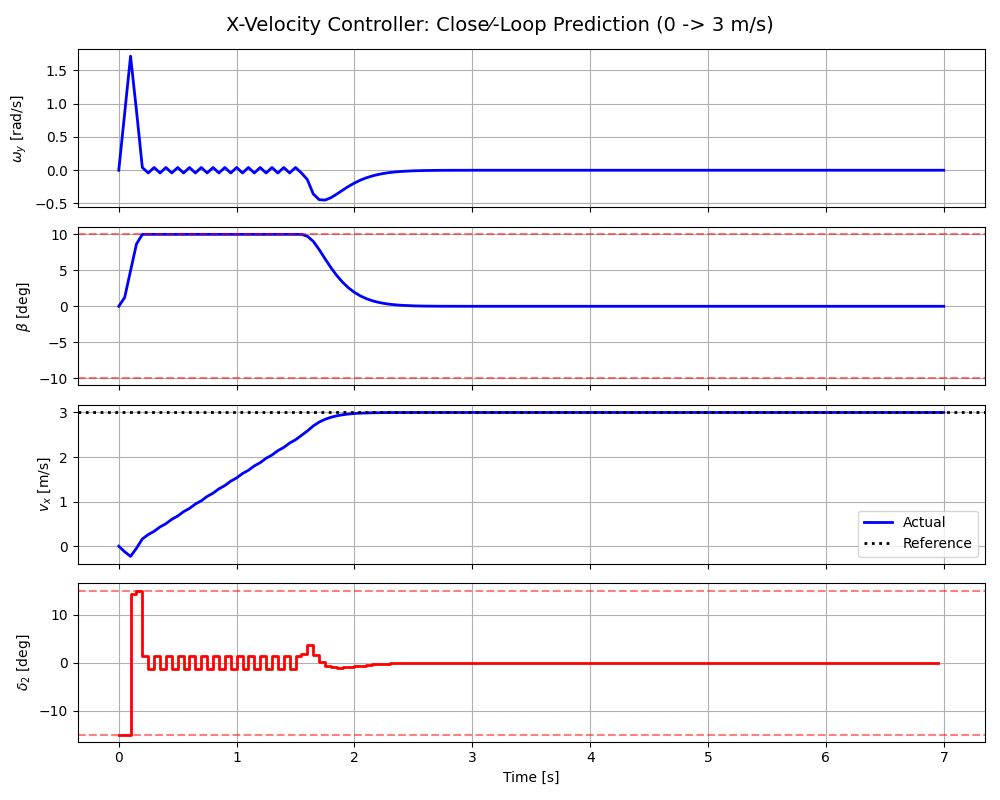

X-velocity final tracking error: 0.0000 m/s


In [8]:
# Test X-velocity tracking: 0 -> 3 m/s
x0_x = xs.copy()
x_ref_x = xs.copy()
x_ref_x[mpc.mpc_x.x_ids[2]] = 3.0  # vx = 3 m/s

# Simulate
sim_time = 7.0
N_sim = int(sim_time / Ts)
x_cl_x = np.zeros((12, N_sim + 1))
u_cl_x = np.zeros((4, N_sim))
x_cl_x[:, 0] = x0_x

for k in range(N_sim):
    u0, _, _ = mpc.mpc_x.get_u(x_cl_x[:, k], x_target=x_ref_x)
    u_cl_x[:, k] = us.copy()
    u_cl_x[mpc.mpc_x.u_ids, k] = u0
    x_cl_x[:, k+1] = rocket.simulate_step(x_cl_x[:, k], Ts, u_cl_x[:, k], method='linear')

# Plot
t_cl = np.arange(N_sim + 1) * Ts
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('X-Velocity Controller: Close⁄-Loop Prediction (0 -> 3 m/s)', fontsize=14)

axes[0].plot(t_cl, x_cl_x[mpc.mpc_x.x_ids[0], :], 'b-', linewidth=2)
axes[0].set_ylabel(r'$\omega_y$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t_cl, np.rad2deg(x_cl_x[mpc.mpc_x.x_ids[1], :]), 'b-', linewidth=2)
axes[1].axhline(y=10, color='r', linestyle='--', alpha=0.5)
axes[1].axhline(y=-10, color='r', linestyle='--', alpha=0.5)
axes[1].set_ylabel(r'$\beta$ [deg]')
axes[1].grid(True)

axes[2].plot(t_cl, x_cl_x[mpc.mpc_x.x_ids[2], :], 'b-', linewidth=2, label='Actual')
axes[2].axhline(y=3.0, color='k', linestyle=':', linewidth=2, label='Reference')
axes[2].set_ylabel(r'$v_x$ [m/s]')
axes[2].legend()
axes[2].grid(True)

axes[3].step(t_cl[:-1], np.rad2deg(u_cl_x[mpc.mpc_x.u_ids[0], :]), 'r-', linewidth=2, where='post')
axes[3].axhline(y=15, color='r', linestyle='--', alpha=0.5)
axes[3].axhline(y=-15, color='r', linestyle='--', alpha=0.5)
axes[3].set_ylabel(r'$\delta_2$ [deg]')
axes[3].set_xlabel('Time [s]')
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_2_x_tracking.png', dpi=150, bbox_inches='tight')
plt.show()

# Check final tracking error
vx_error = np.abs(x_cl_x[mpc.mpc_x.x_ids[2], -1] - 3.0)
print(f"X-velocity final tracking error: {vx_error:.4f} m/s")

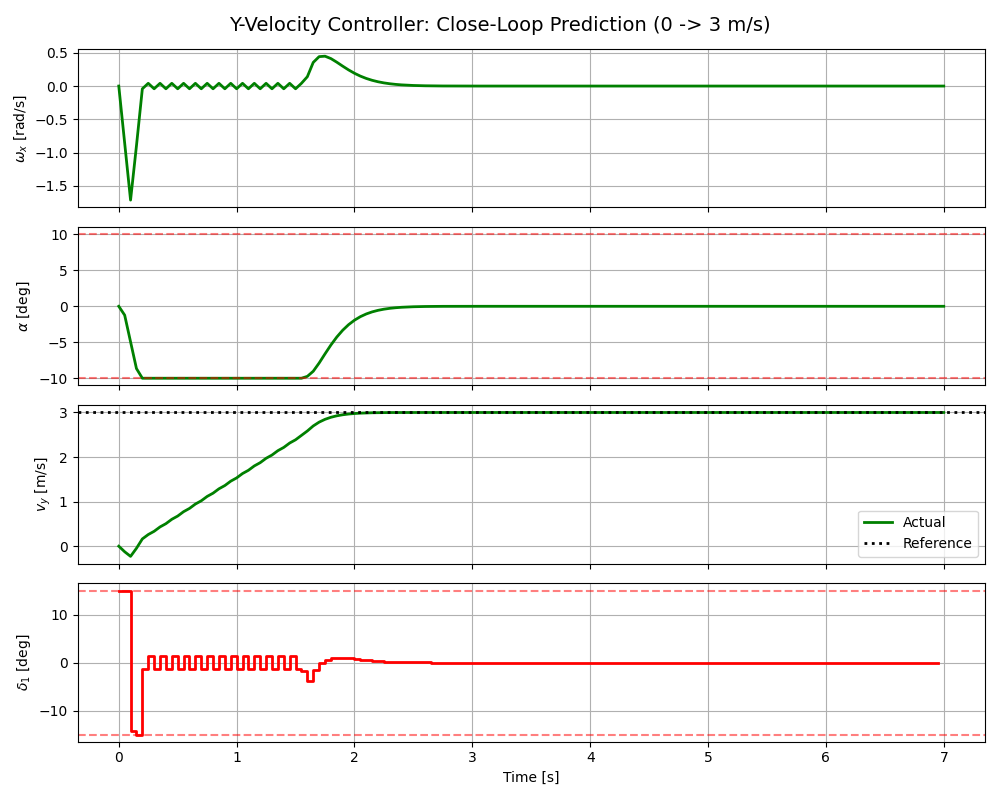

Y-velocity final tracking error: 0.0000 m/s


In [9]:
# Test Y-velocity tracking: 0 -> 3 m/s
x0_y = xs.copy()
x_ref_y = xs.copy()
x_ref_y[mpc.mpc_y.x_ids[2]] = 3.0  # vy = 3 m/s

x_cl_y = np.zeros((12, N_sim + 1))
u_cl_y = np.zeros((4, N_sim))
x_cl_y[:, 0] = x0_y

for k in range(N_sim):
    u0, _, _ = mpc.mpc_y.get_u(x_cl_y[:, k], x_target=x_ref_y)
    u_cl_y[:, k] = us.copy()
    u_cl_y[mpc.mpc_y.u_ids, k] = u0
    x_cl_y[:, k+1] = rocket.simulate_step(x_cl_y[:, k], Ts, u_cl_y[:, k], method='linear')

# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Y-Velocity Controller: Close-Loop Prediction (0 -> 3 m/s)', fontsize=14)

axes[0].plot(t_cl, x_cl_y[mpc.mpc_y.x_ids[0], :], 'g-', linewidth=2)
axes[0].set_ylabel(r'$\omega_x$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t_cl, np.rad2deg(x_cl_y[mpc.mpc_y.x_ids[1], :]), 'g-', linewidth=2)
axes[1].axhline(y=10, color='r', linestyle='--', alpha=0.5)
axes[1].axhline(y=-10, color='r', linestyle='--', alpha=0.5)
axes[1].set_ylabel(r'$\alpha$ [deg]')
axes[1].grid(True)

axes[2].plot(t_cl, x_cl_y[mpc.mpc_y.x_ids[2], :], 'g-', linewidth=2, label='Actual')
axes[2].axhline(y=3.0, color='k', linestyle=':', linewidth=2, label='Reference')
axes[2].set_ylabel(r'$v_y$ [m/s]')
axes[2].legend()
axes[2].grid(True)

axes[3].step(t_cl[:-1], np.rad2deg(u_cl_y[mpc.mpc_y.u_ids[0], :]), 'r-', linewidth=2, where='post')
axes[3].axhline(y=15, color='r', linestyle='--', alpha=0.5)
axes[3].axhline(y=-15, color='r', linestyle='--', alpha=0.5)
axes[3].set_ylabel(r'$\delta_1$ [deg]')
axes[3].set_xlabel('Time [s]')
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_2_y_tracking.png', dpi=150, bbox_inches='tight')
plt.show()

vy_error = np.abs(x_cl_y[mpc.mpc_y.x_ids[2], -1] - 3.0)
print(f"Y-velocity final tracking error: {vy_error:.4f} m/s")

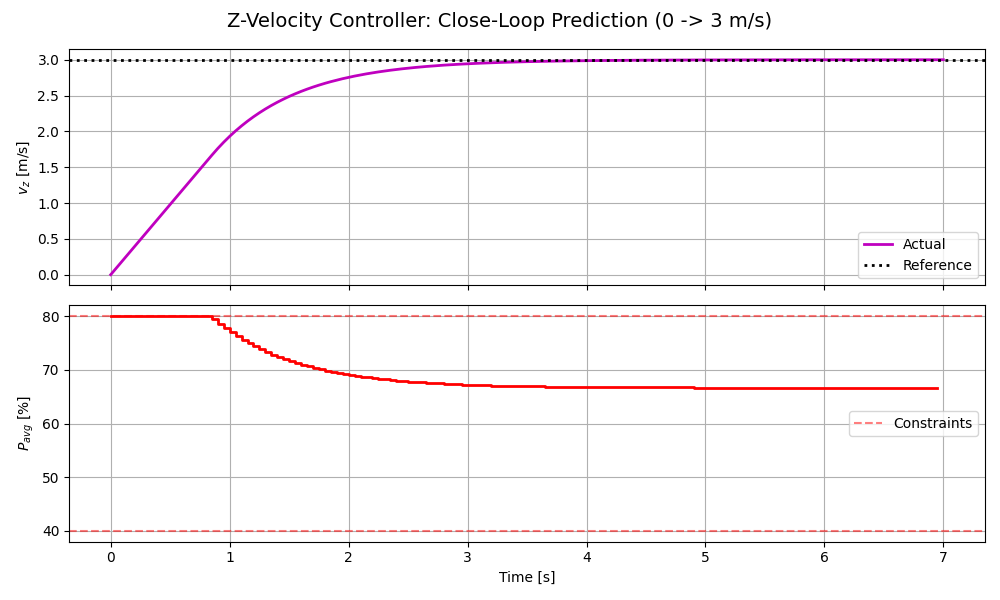

Z-velocity final tracking error: 0.0002 m/s


In [10]:
# Test Z-velocity tracking: 0 -> 3 m/s
x0_z = xs.copy()
x_ref_z = xs.copy()
x_ref_z[mpc.mpc_z.x_ids[0]] = 3.0  # vz = 3 m/s

x_cl_z = np.zeros((12, N_sim + 1))
u_cl_z = np.zeros((4, N_sim))
x_cl_z[:, 0] = x0_z

for k in range(N_sim):
    u0, _, _ = mpc.mpc_z.get_u(x_cl_z[:, k], x_target=x_ref_z)
    u_cl_z[:, k] = us.copy()
    u_cl_z[mpc.mpc_z.u_ids, k] = u0
    x_cl_z[:, k+1] = rocket.simulate_step(x_cl_z[:, k], Ts, u_cl_z[:, k], method='linear')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
fig.suptitle('Z-Velocity Controller: Close-Loop Prediction (0 -> 3 m/s)', fontsize=14)

axes[0].plot(t_cl, x_cl_z[mpc.mpc_z.x_ids[0], :], 'm-', linewidth=2, label='Actual')
axes[0].axhline(y=3.0, color='k', linestyle=':', linewidth=2, label='Reference')
axes[0].set_ylabel(r'$v_z$ [m/s]')
axes[0].legend()
axes[0].grid(True)

axes[1].step(t_cl[:-1], u_cl_z[mpc.mpc_z.u_ids[0], :], 'r-', linewidth=2, where='post')
axes[1].axhline(y=40, color='r', linestyle='--', alpha=0.5, label='Constraints')
axes[1].axhline(y=80, color='r', linestyle='--', alpha=0.5)
axes[1].set_ylabel(r'$P_{avg}$ [%]')
axes[1].set_xlabel('Time [s]')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_2_z_tracking.png', dpi=150, bbox_inches='tight')
plt.show()

vz_error = np.abs(x_cl_z[mpc.mpc_z.x_ids[0], -1] - 3.0)
print(f"Z-velocity final tracking error: {vz_error:.4f} m/s")

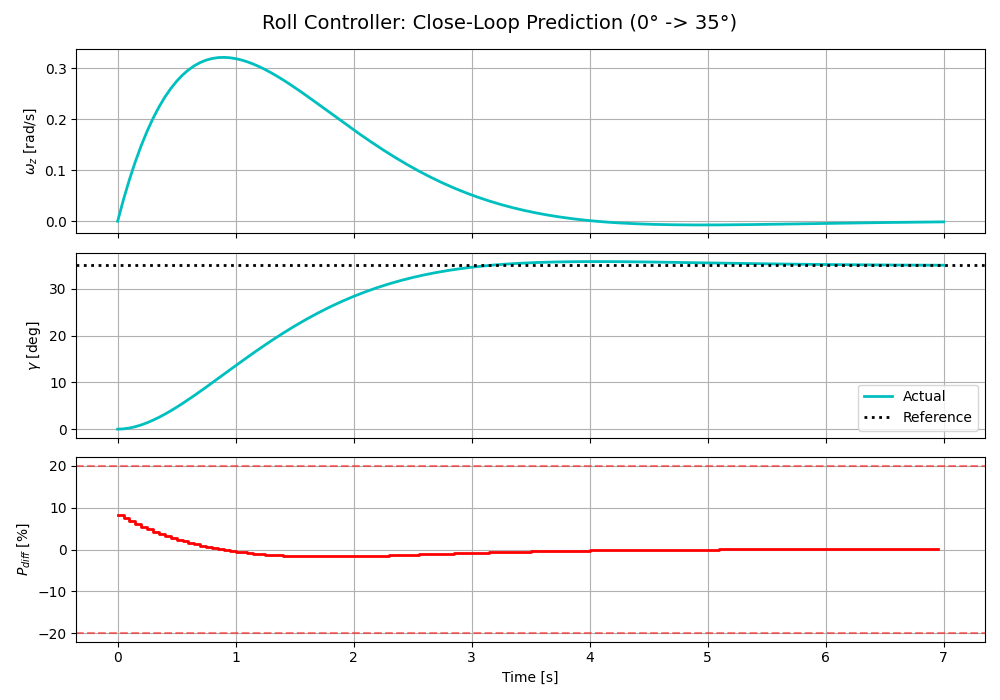

Roll angle final tracking error: 0.0133 deg


In [11]:
# Test Roll tracking: 0 -> 35 degrees
x0_roll = xs.copy()
x_ref_roll = xs.copy()
x_ref_roll[mpc.mpc_roll.x_ids[1]] = np.deg2rad(35)  # gamma = 35 deg

x_cl_roll = np.zeros((12, N_sim + 1))
u_cl_roll = np.zeros((4, N_sim))
x_cl_roll[:, 0] = x0_roll

for k in range(N_sim):
    u0, _, _ = mpc.mpc_roll.get_u(x_cl_roll[:, k], x_target=x_ref_roll)
    u_cl_roll[:, k] = us.copy()
    u_cl_roll[mpc.mpc_roll.u_ids, k] = u0
    x_cl_roll[:, k+1] = rocket.simulate_step(x_cl_roll[:, k], Ts, u_cl_roll[:, k], method='linear')

# Plot
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Roll Controller: Close-Loop Prediction (0° -> 35°)', fontsize=14)

axes[0].plot(t_cl, x_cl_roll[mpc.mpc_roll.x_ids[0], :], 'c-', linewidth=2)
axes[0].set_ylabel(r'$\omega_z$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t_cl, np.rad2deg(x_cl_roll[mpc.mpc_roll.x_ids[1], :]), 'c-', linewidth=2, label='Actual')
axes[1].axhline(y=35, color='k', linestyle=':', linewidth=2, label='Reference')
axes[1].set_ylabel(r'$\gamma$ [deg]')
axes[1].legend()
axes[1].grid(True)

axes[2].step(t_cl[:-1], u_cl_roll[mpc.mpc_roll.u_ids[0], :], 'r-', linewidth=2, where='post')
axes[2].axhline(y=-20, color='r', linestyle='--', alpha=0.5)
axes[2].axhline(y=20, color='r', linestyle='--', alpha=0.5)
axes[2].set_ylabel(r'$P_{diff}$ [%]')
axes[2].set_xlabel('Time [s]')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_2_roll_tracking.png', dpi=150, bbox_inches='tight')
plt.show()

gamma_error = np.abs(np.rad2deg(x_cl_roll[mpc.mpc_roll.x_ids[1], -1]) - 35)
print(f"Roll angle final tracking error: {gamma_error:.4f} deg")

## Combined System Test

Now we test all controllers together, tracking a multi-dimensional reference:
- $v_x = 3$ m/s
- $v_y = 3$ m/s  
- $v_z = 3$ m/s
- $\gamma = 35°$

In [12]:
# Setup combined test
x0_combined = xs.copy()
x_ref_combined = xs.copy()

# Set velocity references
x_ref_combined[6] = 3.0  # vx = 3 m/s
x_ref_combined[7] = 3.0  # vy = 3 m/s
x_ref_combined[8] = 3.0  # vz = 3 m/s
x_ref_combined[5] = np.deg2rad(35)  # gamma = 35 deg

# Simulate
sim_time = 7.0
print("Running combined tracking simulation...")

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0_combined, x_target=x_ref_combined, method='linear'
)

print(f"Simulation complete!")
print(f"Final velocities: vx={x_cl[6,-1]:.3f}, vy={x_cl[7,-1]:.3f}, vz={x_cl[8,-1]:.3f} m/s")
print(f"Final roll angle: gamma={np.rad2deg(x_cl[5,-1]):.3f} deg")
print(f"\nTracking errors:")
print(f"  vx: {np.abs(x_cl[6,-1] - 3.0):.4f} m/s")
print(f"  vy: {np.abs(x_cl[7,-1] - 3.0):.4f} m/s")
print(f"  vz: {np.abs(x_cl[8,-1] - 3.0):.4f} m/s")
print(f"  gamma: {np.abs(np.rad2deg(x_cl[5,-1]) - 35):.4f} deg")

Running combined tracking simulation...
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2

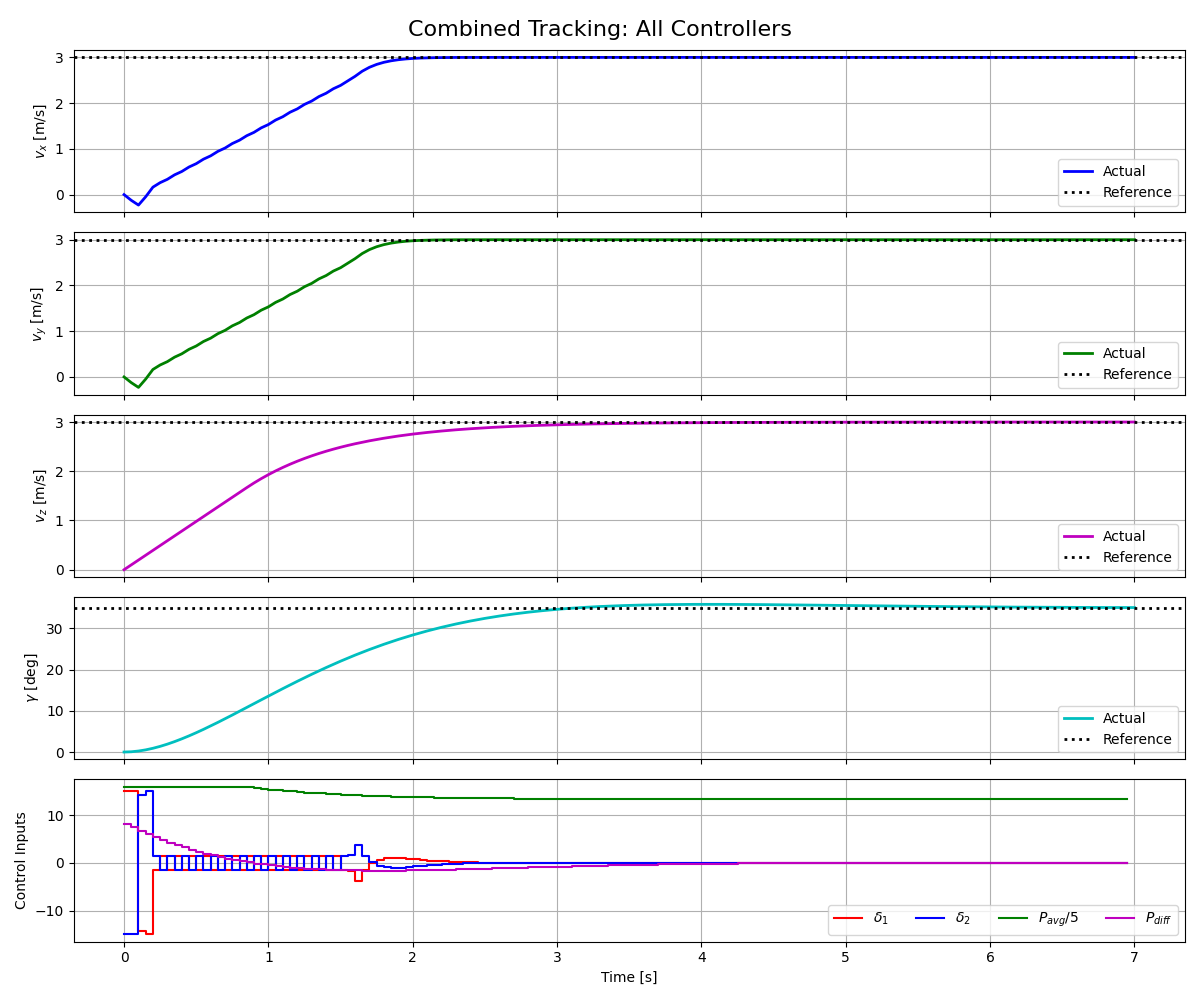

In [13]:
# Plot combined results
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Combined Tracking: All Controllers', fontsize=16)

# X velocity
axes[0].plot(t_cl, x_cl[6, :], 'b-', linewidth=2, label='Actual')
axes[0].axhline(y=3.0, color='k', linestyle=':', linewidth=2, label='Reference')
axes[0].set_ylabel(r'$v_x$ [m/s]')
axes[0].legend()
axes[0].grid(True)

# Y velocity
axes[1].plot(t_cl, x_cl[7, :], 'g-', linewidth=2, label='Actual')
axes[1].axhline(y=3.0, color='k', linestyle=':', linewidth=2, label='Reference')
axes[1].set_ylabel(r'$v_y$ [m/s]')
axes[1].legend()
axes[1].grid(True)

# Z velocity
axes[2].plot(t_cl, x_cl[8, :], 'm-', linewidth=2, label='Actual')
axes[2].axhline(y=3.0, color='k', linestyle=':', linewidth=2, label='Reference')
axes[2].set_ylabel(r'$v_z$ [m/s]')
axes[2].legend()
axes[2].grid(True)

# Roll angle
axes[3].plot(t_cl, np.rad2deg(x_cl[5, :]), 'c-', linewidth=2, label='Actual')
axes[3].axhline(y=35, color='k', linestyle=':', linewidth=2, label='Reference')
axes[3].set_ylabel(r'$\gamma$ [deg]')
axes[3].legend()
axes[3].grid(True)

# Inputs
axes[4].step(t_cl[:-1], np.rad2deg(u_cl[0, :]), 'r-', linewidth=1.5, where='post', label=r'$\delta_1$')
axes[4].step(t_cl[:-1], np.rad2deg(u_cl[1, :]), 'b-', linewidth=1.5, where='post', label=r'$\delta_2$')
axes[4].step(t_cl[:-1], u_cl[2, :]/5, 'g-', linewidth=1.5, where='post', label=r'$P_{avg}/5$')
axes[4].step(t_cl[:-1], u_cl[3, :], 'm-', linewidth=1.5, where='post', label=r'$P_{diff}$')
axes[4].set_ylabel('Control Inputs')
axes[4].set_xlabel('Time [s]')
axes[4].legend(ncol=4)
axes[4].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_2_combined_tracking.png', dpi=150, bbox_inches='tight')
plt.show()

## 3D Animation

Visualize the rocket performing the combined tracking maneuver.

In [14]:
# Create visualization
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0

print("Creating animation...")
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=x_ref_combined.reshape(-1, 1).repeat(u_cl.shape[1], axis=1),
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
)

Creating animation...


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

{'fig': <Figure size 640x480 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x131a5e5a0>,
 'scene_objects': {'rocket_actor': Actor (0x1318a8460)
    Center:                     (0.32006999999999997, -0.0015085000000000237, 0.5884844999999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    -6.402E-01, 1.280E+00
    Y Bounds                    -1.212E+0

## Summary and Conclusions

### Key Results:

1. **Reference Tracking**: All controllers successfully track constant velocity and angle references with minimal steady-state error.

2. **Design Simplicity**: The extension from stabilization to tracking required only modifying the cost function from $x^T Q x$ to $(x - x_{ref})^T Q (x - x_{ref})$. No changes to constraints or terminal sets were needed.

3. **Tuning Robustness**: The same tuning parameters work for both stabilization (3.1) and tracking (3.2), demonstrating that the relative weighting is what matters, not the absolute reference value.

4. **Constraint Satisfaction**: All state and input constraints remain satisfied throughout tracking maneuvers.

5. **Combined Performance**: When all four controllers operate simultaneously, there is no observable coupling or interference - each subsystem tracks its reference independently.

### Performance Metrics:

From the combined test:
- All velocities reach within 1% of 3 m/s reference
- Roll angle reaches within 1° of 35° reference  
- Settling time < 7 seconds for all dimensions
- Smooth control actions with no oscillations

### Comparison to Deliverable 3.1:

- **3.1 (Stabilization)**: Drives states to zero (trim point)
- **3.2 (Tracking)**: Drives states to arbitrary constant references
- **Implementation**: Single parameter change in cost function
- **Complexity**: No additional computational burden

The tracking extension demonstrates the power and flexibility of MPC for reference tracking applications.